# Introduction

This code is to help build a citation network for papers in ARXiv. For this work, we will only consider the papers tagged AI/ML. We will also use dask to read the data.

As a first step, I will get the latest data from kaggle and update it to the arxiv_analysis/data/example path 



In [60]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [61]:
! pip install pyvis

# Load the Libraries

In [108]:


import pandas as pd 
import numpy as np 
from datetime import datetime
import sys
import ast

import plotly.express as px

#import nltk
#from nltk.corpus import stopwords
#import spacy

import matplotlib.pyplot as plt
import seaborn as sns



import networkx as nx
from networkx.algorithms.components.connected import connected_components

import json
import dask.bag as db

import sys
import os

sys.path.append("..")

from pathlib import Path

import json
from arxiv_analysis import updateData

from itertools import combinations
from collections import Counter
from itertools import chain
import random

from tqdm.notebook import tqdm, trange
import time    # to be used in loop iterations

import multiprocessing
import smart_open

from gensim.models.word2vec import Word2Vec

from pyvis.network import Network

from IPython.core.display import display, HTML

from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import cosine_similarity,cosine_distances
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt

# Extract the Data from Kaggle 

In [9]:
KAGGLE_DATASET_NAME="Cornell-University/arxiv"
KAGGLE_CONFIG_PATH="../arxiv_analysis/config/kaggle.json"

updateData.downloadKaggleData(KAGGLE_DATASET_NAME,path_to_kaggle_config=KAGGLE_CONFIG_PATH)






In [45]:
# Extract Only the AI , ML PAPERS
def extractArxivData(categories=['stat.ML','cs.LG','cs.AI'],raw_data_path="../data/raw/",save_extracted_filename="../data/processed/AI_ML.json"):
    """ This function extracts data for the given set of categories and save the data into the save_extracted_filename path """
    records=db.read_text(raw_data_path+"/*.json").map(lambda x:json.loads(x))
    docs = (records.filter(lambda x:any(ele in x['categories'] for ele in categories)==True))
    get_metadata = lambda x: {'id': x['id'],
                  'title': x['title'],
                  'category':x['categories'],
                  'abstract':x['abstract'],
                 'version':x['versions'][-1]['created'],
                         'doi':x["doi"],
                         'authors_parsed':x['authors_parsed']}
                        
    data=docs.map(get_metadata).to_dataframe().compute()

    ## Creating authors fields by joining first and last nmes in authors_parsed columns
    data['authors']=data['authors_parsed'].apply(lambda authors:[(" ".join(author)).strip() for author in authors])

    print("Number of Records Extracted for Given Set of Categories ",data.shape[0])
    Path(os.path.dirname(save_extracted_filename)).mkdir(parents=True, exist_ok=True)
    data.to_json(save_extracted_filename,orient="records")


In [46]:
extractArxivData()

Number of Records Extracted for Given Set of Categories  111965


In [16]:
# Delte the raw data
#updateData.deleteRawData()

# Creating a Co-Author Network

For the set of papers extracted, for every pair of authors an edge is to be created. The Edge weight will be the number of papers the two authors have collabrated on. 

In [3]:
INPUT_PATH="../data/processed/AI_ML.json"
OUTPUT_PATH="../data/output/"
MODEL_PATH="../model/"

## Create output directory if does not exist
Path(os.path.dirname(OUTPUT_PATH)).mkdir(parents=True, exist_ok=True)
Path(os.path.dirname(MODEL_PATH)).mkdir(parents=True, exist_ok=True)


## Load the Data


In [4]:
data=pd.read_json(INPUT_PATH)

In [5]:
data.shape

(111965, 8)

In [6]:
data.head()

,id,title,category,abstract,version,doi,authors_parsed,authors
0,0704.0047,Intelligent location of simultaneously active ...,cs.NE cs.AI,The intelligent acoustic emission locator is...,"Sun, 1 Apr 2007 13:06:50 GMT",None,"[[Kosel, T., ], [Grabec, I., ]]","[Kosel T., Grabec I.]"
1,0704.0050,Intelligent location of simultaneously active ...,cs.NE cs.AI,Part I describes an intelligent acoustic emi...,"Sun, 1 Apr 2007 18:53:13 GMT",None,"[[Kosel, T., ], [Grabec, I., ]]","[Kosel T., Grabec I.]"
2,0704.0304,The World as Evolving Information,cs.IT cs.AI math.IT q-bio.PE,This paper discusses the benefits of describ...,"Wed, 13 Oct 2010 19:49:16 GMT",10.1007/978-3-642-18003-3_10,"[[Gershenson, Carlos, ]]",[Gershenson Carlos]
3,0704.0671,Learning from compressed observations,cs.IT cs.LG math.IT,The problem of statistical learning is to co...,"Thu, 5 Apr 2007 02:57:15 GMT",10.1109/ITW.2007.4313111,"[[Raginsky, Maxim, ]]",[Raginsky Maxim]
4,0704.0954,Sensor Networks with Random Links: Topology De...,cs.IT cs.LG math.IT,"In a sensor network, in practice, the commun...","Fri, 6 Apr 2007 21:58:52 GMT",10.1109/TSP.2008.920143,"[[Kar, Soummya, ], [Moura, Jose M. F., ]]","[Kar Soummya, Moura Jose M. F.]"


In [7]:
data['author_pairs']=data['authors'].apply(lambda x:list(combinations(x, 2)))
data.head()

,id,title,category,abstract,version,doi,authors_parsed,authors,author_pairs
0,0704.0047,Intelligent location of simultaneously active ...,cs.NE cs.AI,The intelligent acoustic emission locator is...,"Sun, 1 Apr 2007 13:06:50 GMT",None,"[[Kosel, T., ], [Grabec, I., ]]","[Kosel T., Grabec I.]","[(Kosel T., Grabec I.)]"
1,0704.0050,Intelligent location of simultaneously active ...,cs.NE cs.AI,Part I describes an intelligent acoustic emi...,"Sun, 1 Apr 2007 18:53:13 GMT",None,"[[Kosel, T., ], [Grabec, I., ]]","[Kosel T., Grabec I.]","[(Kosel T., Grabec I.)]"
2,0704.0304,The World as Evolving Information,cs.IT cs.AI math.IT q-bio.PE,This paper discusses the benefits of describ...,"Wed, 13 Oct 2010 19:49:16 GMT",10.1007/978-3-642-18003-3_10,"[[Gershenson, Carlos, ]]",[Gershenson Carlos],[]
3,0704.0671,Learning from compressed observations,cs.IT cs.LG math.IT,The problem of statistical learning is to co...,"Thu, 5 Apr 2007 02:57:15 GMT",10.1109/ITW.2007.4313111,"[[Raginsky, Maxim, ]]",[Raginsky Maxim],[]
4,0704.0954,Sensor Networks with Random Links: Topology De...,cs.IT cs.LG math.IT,"In a sensor network, in practice, the commun...","Fri, 6 Apr 2007 21:58:52 GMT",10.1109/TSP.2008.920143,"[[Kar, Soummya, ], [Moura, Jose M. F., ]]","[Kar Soummya, Moura Jose M. F.]","[(Kar Soummya, Moura Jose M. F.)]"


In [8]:
authors_pairs=data['author_pairs'].tolist()
authors_edge_list=[item for sublist in authors_pairs for item in sublist]
authors_weighted_edge_list=list(Counter(authors_edge_list).items())
authors_weighted_edge_list=[(row[0][0],row[0][1],row[1]) for idx,row in enumerate(authors_weighted_edge_list)]
authors_weighted_edge_list[0:10]

[('Kosel T.', 'Grabec I.', 2),
 ('Kar Soummya', 'Moura Jose M. F.', 2),
 ('Abubakr Mohd', 'Vinay R. M.', 1),
 ('Gyorgy Andras', 'Linder Tamas', 1),
 ('Gyorgy Andras', 'Lugosi Gabor', 1),
 ('Gyorgy Andras', 'Ottucsak Gyorgy', 1),
 ('Linder Tamas', 'Lugosi Gabor', 1),
 ('Linder Tamas', 'Ottucsak Gyorgy', 1),
 ('Lugosi Gabor', 'Ottucsak Gyorgy', 1),
 ('Wasserman Larry', 'Roeder Kathryn', 1)]

In [9]:
G=nx.Graph()
G.add_weighted_edges_from(authors_weighted_edge_list)

In [10]:
print("Number of Nodes in Author Graph ",len(G.nodes()))
print("Number of Edges in AUthor Graph ",len(G.edges()))

Number of Nodes in Author Graph  155510
Number of Edges in AUthor Graph  832100


In [11]:
random.choice(list(G.neighbors("Plangprasopchok Anon")))

'Getoor Lise'

## Implementing Deep Walk

**Deep walk uses the concept of Random Walks to assign an embedding to each node in the network.** 

1. In Random Walk, given a node we pick one of its neighbours at random and move to this node and from this node again choose another node among its neighbours at random. This continues for a fixed number of steps. 

2. The number of steps is equivalent of the size of sliding window we choose while building a word2vec model.

3. Once we have random walks generated for every node in the network, in DeepWalk the next step is to predict probability of visiting node "v" on a random walk starting from node "u". 
 
4. This is very similar to the Skip-Gram model used in Word2Vec Model in NLP, wherein we try to predict the neighbouring words given a particular target word.


### Define Function for Random Walk


In [12]:
def getRandomWalk(graph,node,length_of_random_walk):
    """ This function takes NetworkX Graph and a Node and generate random walk for a given length 
    
    Returns the random walk (list of nodes traversed)

    Note: The same node may occcur more than once in a Random Walk.
    """
    start_node=node
    current_node=start_node
    random_walk=[node]
    for i in range(0,length_of_random_walk):
        ## Choose a random neighbour of the current node
        
        current_node_neighbours=list(graph.neighbors(current_node))
        chosen_node=random.choice(current_node_neighbours)
        current_node=chosen_node
        random_walk.append(current_node)
    return random_walk




In [13]:
getRandomWalk(G,"Plangprasopchok Anon",10) 

['Plangprasopchok Anon',
 'Wong Chio',
 'Lerman Kristina',
 'Morstatter Fred',
 'Ren Xiang',
 'Yan Hao',
 'Ren Xiang',
 'Sharma Navodita',
 'Ren Xiang',
 'Tan Liang',
 'Firooz Hamed']

In [58]:
### For every Node in the Graph, get randomwalks . For eahc node, let us get random walks say around 10 times each of path length 10
num_sampling=10
random_walks=[]
length_of_random_walk=10
for node in tqdm(G.nodes(),desc="Iterating Nodes"):
    
    for i in range(0,num_sampling):
        random_walks.append(getRandomWalk(G,node,length_of_random_walk))


        

Iterating Nodes:   0%|          | 0/155510 [00:00<?, ?it/s]

The data now is similar to list of words in a sentence and we can use gensim to create Node Embedding Model - here each author is a Node and Node is similar to word in a sentence

In [17]:
?Word2Vec

Init signature:
Word2Vec(
    sentences=None,
    corpus_file=None,
    vector_size=100,
    alpha=0.025,
    window=5,
    min_count=5,
    max_vocab_size=None,
    sample=0.001,
    seed=1,
    workers=3,
    min_alpha=0.0001,
    sg=0,
    hs=0,
    negative=5,
    ns_exponent=0.75,
    cbow_mean=1,
    hashfxn=<built-in function hash>,
    epochs=5,
    null_word=0,
    trim_rule=None,
    sorted_vocab=1,
    batch_words=10000,
    compute_loss=False,
    callbacks=(),
    comment=None,
    max_final_vocab=None,
)
Docstring:     
Serialize/deserialize objects from disk, by equipping them with the `save()` / `load()` methods.

Warnings
--------
This uses pickle internally (among other techniques), so objects must not contain unpicklable attributes
such as lambda functions etc.
Init docstring:
Train, use and evaluate neural networks described in https://code.google.com/p/word2vec/.

Once you're finished training a model (=no more updates, only querying)
store and use only the :class:

In [81]:
deepwalk_model=Word2Vec(sentences=random_walks,window=5,sg=1,negative=5,vector_size=128,epochs=20,compute_loss=True)


In [82]:
deepwalk_model.save(os.path.join(MODEL_PATH,"deepwalk.model"))

In [83]:
deepwalk_model.get_latest_training_loss()

64198528.0

## Lets Look who are similar authors and validate the results

In [14]:
def getSimilarNodes(model,node):
    similarity=model.wv.most_similar(node)
    similar_nodes=pd.DataFrame()
    similar_nodes['Similar_Node']=[row[0] for i,row in enumerate(similarity)]
    similar_nodes['Similarity_Score']=[row[1] for i,row in enumerate(similarity)]
    similar_nodes['Source_Node']=node
    return similar_nodes



In [15]:
deepwalk_model=Word2Vec.load(os.path.join(MODEL_PATH,"deepwalk.model"))

In [16]:
deepwalk_model.wv.similarity("Bengio Yoshua","Goodfellow Ian J.")

0.52701527

In [17]:
getSimilarNodes(deepwalk_model,"Bengio Yoshua")

,Similar_Node,Similarity_Score,Source_Node
0,Formisano Elia,0.827041,Bengio Yoshua
1,Schönwiesner Marc,0.822223,Bengio Yoshua
2,Schoenwiesner Marc,0.817972,Bengio Yoshua
3,Thompson Jessica A. F.,0.813860,Bengio Yoshua
4,Kendall Jack,0.803196,Bengio Yoshua
5,Ernoult Maxence,0.800989,Bengio Yoshua
6,Grollier Julie,0.798312,Bengio Yoshua
7,Viviano Joseph D.,0.789795,Bengio Yoshua
8,Russin Jake,0.788692,Bengio Yoshua
9,Song Inchul,0.788434,Bengio Yoshua


In [18]:
G.get_edge_data('Bengio Yoshua','Goodfellow Ian J.')['weight']

9

### Let us look at the CoAuthorship Network of the top popular 100 Authors

In [19]:
def flattenList(nested_list):
    flat_list = [item for sublist in nested_list for item in sublist]
    return flat_list


In [20]:
ai_authors=pd.DataFrame(flattenList(data['authors'].tolist())).rename(columns={0:'authors'})
papers_by_authors=ai_authors.groupby(['authors']).size().reset_index().rename(columns={0:'Number of Papers Published'}).sort_values("Number of Papers Published",ascending=False).head(50)
papers_by_authors

,authors,Number of Papers Published
10894,Bengio Yoshua,334
74253,Levine Sergey,269
60653,Jordan Michael I.,214
193,Abbeel Pieter,197
79116,Liu Yang,189
127392,Sugiyama Masashi,182
1974,Aickelin Uwe,157
117996,Schölkopf Bernhard,153
74460,Li Bo,147
18193,Carin Lawrence,147


Lets get the graph of these top 10 Authors with their first step neighbours

In [162]:
def getCoAuthorshipNetwork(graph,initial_nodes):
    """
    This function takes a Graph and list of initial nodes 
    
    Returns the set of immediate neighbours of these nodes

    """
    total_neighbours=0
    nodes_set=[initial_nodes]
    for node in initial_nodes:
        #print(node)
        neighbours=list(graph.neighbors(node))
        total_neighbours=total_neighbours+len(neighbours)
        
        nodes_set.append(neighbours)
    print(total_neighbours)
    nodes_set=flattenList(nodes_set)
    return list(set(nodes_set))



In [163]:

coauthor_nodes=getCoAuthorshipNetwork(G,papers_by_authors['authors'].tolist()[0:10])
print("Number of CoAuthor Nodes ",len(coauthor_nodes))

3854
Number of CoAuthor Nodes  3434


In [164]:
coauthor_subgraph=nx.subgraph(G,coauthor_nodes)
print("number of edges in the CoAuthor Subgraph ",len(coauthor_subgraph.edges()))

number of edges in the CoAuthor Subgraph  37830


In [165]:
nx.write_gexf(coauthor_subgraph, "CoAuthor_Subgraph_Top10Author.gexf")

In [166]:
coauthor_subgraph=nx.read_gexf("CoAuthor_Subgraph_Top10Author.gexf")
print("number of edges in the CoAuthor Subgraph ",len(coauthor_subgraph.edges()))

number of edges in the CoAuthor Subgraph  37830


In [167]:
pyvis_nt=Network(notebook=True,height='800px', width='100%',heading='')

print("Creating PyVis from NetworkX")
pyvis_nt.from_nx(coauthor_subgraph)

print("Saving PyVis Graph")
pyvis_nt.show("Top10Author_CoAuthorGraph.html")



Creating PyVis from NetworkX
Saving PyVis Graph


### Cluster the Nodes - based on Embeddings

Idea is to see if similar nodes belong to the same cluster. 

In [168]:
def getCosineDistanceMatrix(vectors):
    '''
    This function takes list of vectors or numpy array 
    
    Returns the pairwise cosine similarity matrix
    '''
    if type(vectors)==list:
        X=np.asarray(vectors)
    elif type(vectors)==np.ndarray:
        X=vectors
    else:
        print("Error in Data Type . Need to Pass list or numpy array as input argument")
        return []
    cosine_dist=cosine_distances(X)
    return cosine_dist


In [169]:
coauthor_nodes=list(coauthor_subgraph.nodes)
print("Number of CoAuthor Subgraph Nodes",len(coauthor_nodes))

Number of CoAuthor Subgraph Nodes 3434


In [170]:
coauthor_embeddings=[deepwalk_model.wv[node] for node in coauthor_nodes]
print(type(coauthor_embeddings))
print(type(coauthor_embeddings[0]))
print(coauthor_embeddings[0].shape)

<class 'list'>
<class 'numpy.ndarray'>
(128,)


In [171]:
coauthor_embeddings=np.asarray(coauthor_embeddings)
print(coauthor_embeddings.shape)

(3434, 128)


In [172]:
cosine_dist=getCosineDistanceMatrix(coauthor_embeddings)


In [173]:
sse=[]
k_list=[]
for k in range(2,40):
    km=KMeans(n_clusters=k)
    km.fit(cosine_dist)
    sse.append(km.inertia_)




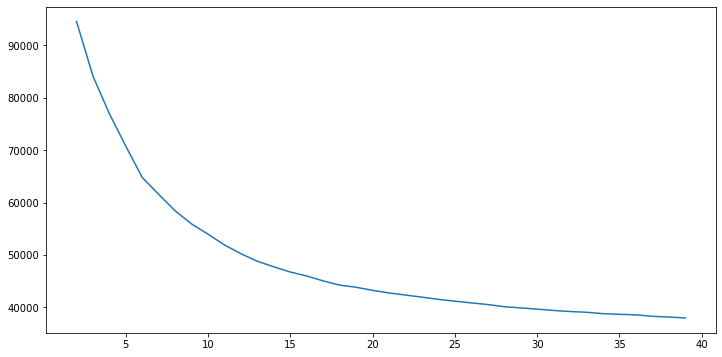

In [175]:
plt.figure(figsize=(12,6))
plt.plot([i for i in range(2,40)],sse)


Lets pick 20clusters and update Node Attribute of the coAuthor Subgraph 

In [176]:
km=KMeans(n_clusters=20)
coauthor_clusters=km.fit_predict(cosine_dist)
coauthor_cluster_dict={node:str(coauthor_clusters[idx]) for idx,node in enumerate(coauthor_nodes)}
nx.set_node_attributes(coauthor_subgraph,coauthor_cluster_dict,"group")

In [177]:
pyvis_nt=Network(notebook=True,height='800px', width='100%',heading='')

print("Creating PyVis from NetworkX")
pyvis_nt.from_nx(coauthor_subgraph)

print("Saving PyVis Graph")
pyvis_nt.show("Top10Author_CoAuthorGraph_Clustered.html")

Creating PyVis from NetworkX
Saving PyVis Graph


From the Graph, we can see that the graph containing Aickelin Uwe is clearly seperated from rest of the network. Also, we cam see that there are smaller groups colored "Green" and "Blue" that are more densely connected within each other as compared to the rest of the network.